In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time

In [2]:
import models.graphene_thermodynamics_v2 as gt

In [3]:
time1 = time.time()
mm = gt.mu_func_use_2d_interpolation(
    dens_min=1.0e-7, dens_max=1.0, dens_num=101,
    tempK_min=5.0, tempK_max=4000.0, tempK_num=121,
    muMin=-6.0, muMax=2.0, proc_num=24,
    save_to="mu_table.pkl")
time2 = time.time()
print("Elapsed: %d" % int(time2 - time1))

Elapsed: 9


In [4]:
# Check that we get the same results with import.
mm1 = gt.mu_func_use_2d_interpolation(load_from="mu_table.pkl")

In [5]:
print( np.abs(mm["tempK_log_list"] - mm1["tempK_log_list"]).max() )
print( np.abs(mm["dens_log_list"] - mm1["dens_log_list"]).max() )
print( np.abs(mm["oneband_mu_mesh"] - mm1["oneband_mu_mesh"]).max() )
print( np.abs(mm["twobands_mu_mesh_n"] - mm1["twobands_mu_mesh_n"]).max() )

0.0
0.0
0.0
0.0


In [6]:
# Get interpolation data.
ttK = mm["tempK_log_list"]
dd = mm["dens_log_list"]
mu_mesh = mm["oneband_mu_mesh"]
muC_mesh = mm["twobands_mu_mesh_n"]

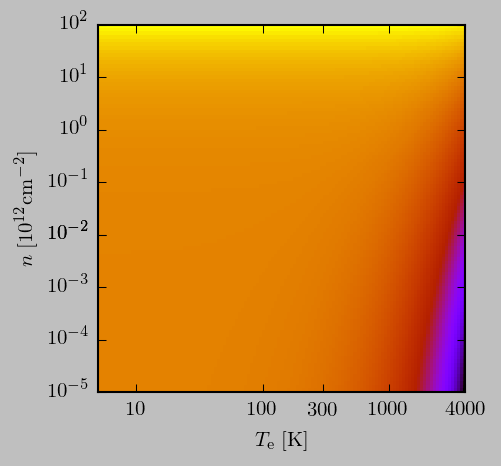

In [7]:
# Plot all data to check where the calculation routine fails.
mpl.style.use(["classic", "latex"])
fig1 = plt.figure(figsize=(3.5,3.5), frameon=True, dpi=150)
plt.axes([0.2,0.2,0.7,0.7])
plt.imshow(mu_mesh, origin="lower", cmap="gnuplot", extent=(ttK[0],ttK[-1],dd[0],dd[-1]), interpolation="none", aspect="auto")
tempK_vals = [10.0, 100.0, 300.0, 1000.0, 4000.0]
plt.xticks(ticks=[np.log10(x) for x in tempK_vals], labels=[r"$%.0f$" % x for x in tempK_vals])
plt.xlabel(r"$T_{\rm e}~[{\rm K}]$")
dens_vals = [1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0]
plt.yticks(ticks=[np.log10(x) for x in dens_vals], labels=[r"$10^{%d}$" % np.log10(100.0*x) for x in dens_vals])
plt.ylabel(r"$n~[10^{12}{\rm cm}^{-2}]$");

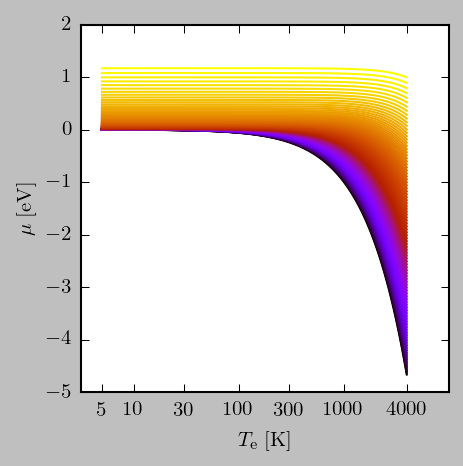

In [11]:
# Plot cuts to check if the function is smooth enough to be reliably interpolated.
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap('gnuplot')
fig2 = plt.figure(figsize=(3.5,3.5), frameon=True, dpi=150)
plt.axes([0.2,0.2,0.7,0.7])
for d,dtK in zip(dd[:], mu_mesh[:]):
    plt.plot(ttK, dtK, "-", color=cmap((d-dd[0])/(dd[-1]-dd[0])) )
tempK_vals = [5.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 4000.0]
plt.xticks(ticks=[np.log10(x) for x in tempK_vals], labels=[r"$%.0f$" % x for x in tempK_vals])
plt.xlabel(r"$T_{\rm e}~[{\rm K}]$")
plt.ylabel(r"$\mu~[{\rm eV}]$");

In [12]:
# Calculate mu for random values with both bisection and interpolation on the given mesh.
nv = 1000
tempK_vals = np.random.uniform(low=200.0, high=4000.0, size=(nv,))
dens_vals = np.random.uniform(low=1.0e-5, high=1.0, size=(nv,))
time1 = time.time()
mu_bisect = np.array([gt.oneband_mu_func_bisect(dens,tempK,muMin=-4.0,muMax=2.0) for dens,tempK in zip(dens_vals,tempK_vals)])
time2 = time.time()
mu_interp = np.array([gt.oneband_mu_func_interp2d(dens,tempK) for dens,tempK in zip(dens_vals,tempK_vals)])
time3 = time.time()

In [13]:
# Compare elapsed time.
print("Bisection: %d" % (time2-time1))
print("Interpolation: %d" % (time3-time2))

Bisection: 5
Interpolation: 0


In [14]:
# Compare the results.
rel_err = np.abs(mu_interp-mu_bisect) / ((mu_interp + mu_bisect) / 2.0)
# Select 10 larger relative errors and print the corresponding input.
ierr = np.argsort(rel_err)[::-1][:10]
for i in ierr:
    print("%5.3f  %04d %8.5f" % (dens_vals[i], int(tempK_vals[i]), rel_err[i]))

0.070  2769  0.04205
0.065  2646  0.04065
0.103  3312  0.02253
0.060  2565  0.01964
0.145  3832  0.00931
0.046  2124  0.00759
0.065  2508  0.00683
0.097  3107  0.00632
0.140  3659  0.00571
0.064  2357  0.00442


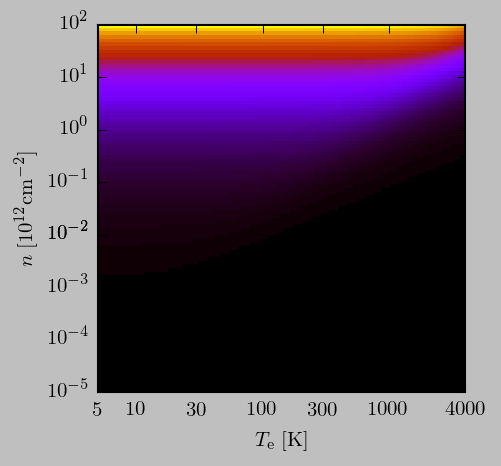

In [17]:
# Similar checks for the two-bands chemical potentials.
mpl.style.use(["classic", "latex"])
fig3 = plt.figure(figsize=(3.5,3.5), frameon=True, dpi=150)
plt.axes([0.2,0.2,0.7,0.7])
plt.imshow(muC_mesh, origin="lower", cmap="gnuplot", extent=(ttK[0],ttK[-1],dd[0],dd[-1]), interpolation="none", aspect="auto")
tempK_vals = [5.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 4000.0]
plt.xticks(ticks=[np.log10(x) for x in tempK_vals], labels=[r"$%.0f$" % x for x in tempK_vals])
plt.xlabel(r"$T_{\rm e}~[{\rm K}]$")
dens_vals = [1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0]
plt.yticks(ticks=[np.log10(x) for x in dens_vals], labels=[r"$10^{%d}$" % np.log10(100.0*x) for x in dens_vals])
plt.ylabel(r"$n~[10^{12}{\rm cm}^{-2}]$");

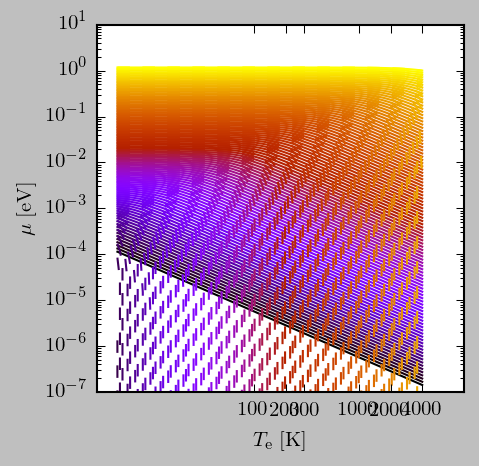

In [18]:
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap('gnuplot')
fig5 = plt.figure(figsize=(3.5,3.5), frameon=True, dpi=150)
plt.axes([0.2,0.2,0.7,0.7])
for d,dtK in zip(dd[:], muC_mesh[:]):
    plt.plot(ttK, dtK, "-", color=cmap((d-dd[0])/(dd[-1]-dd[0])) )
# Plot the one-band chemical potential to verify the convergence at small temperature.
for d,dtK in zip(dd[:], mu_mesh[:]):
    plt.plot(ttK, dtK, "--", color=cmap((d-dd[0])/(dd[-1]-dd[0])) )
tempK_vals = [100.0, 200.0, 300.0, 1000.0, 2000.0, 4000.0]
plt.xticks(ticks=[np.log10(x) for x in tempK_vals], labels=[r"$%.0f$" % x for x in tempK_vals])
plt.xlabel(r"$T_{\rm e}~[{\rm K}]$")
plt.yscale("log")
plt.ylim([1.0e-7, 10.0])
plt.ylabel(r"$\mu~[{\rm eV}]$");

In [19]:
# Save plots to files.
run_label = "test_mu_larger"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/01/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

fig1.savefig("%s/mu_data.png" % saveDir, dpi=300)
fig2.savefig("%s/mu_cuts.png" % saveDir, dpi=300)
fig5.savefig("%s/mu_cuts_comp.png" % saveDir, dpi=300)